In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [128]:
# Carregar o conjunto de dados
df = pd.read_csv('../data/commerce_dataset_clean.csv', sep=';')

In [129]:
# Converter a coluna 'dtme' para datetime e definir como índice do DataFrame
df['dtme'] = pd.to_datetime(df['dtme'])
df.set_index('dtme', inplace=True)

## SARIMA

In [130]:
# Agregar os dados para obter o total de vendas por dia
daily_sales = df['total'].resample('D').sum()

# Dividir os dados em conjunto de treinamento (20%) e teste (80%)
split_point = int(len(daily_sales) * 0.2)
train_data, test_data = daily_sales[:split_point], daily_sales[split_point:]

# Exibir as primeiras linhas do conjunto de treinamento e teste para verificação
train_data.head(), test_data.head(), len(train_data), len(test_data)

(dtme
 2019-01-01    4745.1810
 2019-01-02    1945.5030
 2019-01-03    2078.1285
 2019-01-04    1623.6885
 2019-01-05    3536.6835
 Freq: D, Name: total, dtype: float64,
 dtme
 2019-01-18    2780.4735
 2019-01-19    4914.7245
 2019-01-20    3655.4490
 2019-01-21    2392.0995
 2019-01-22    1704.7695
 Freq: D, Name: total, dtype: float64,
 17,
 72)

In [131]:
# Definir parâmetros iniciais para o modelo SARIMA
# Estes parâmetros podem precisar de ajuste baseado em diagnósticos do modelo ou conhecimento do domínio

# Non-seasonal components
p, d, q = 1, 1, 1  
# p: The order of the autoregressive part of the model.
# d: The degree of first differencing involved.
# q: The order of the moving average part of the model.

# Seasonal components
# P, D, Q, m = 1, 1, 2, 7  
P, D, Q, m = 2, 1, 1, 7  
# P: The order of the seasonal autoregressive part of the model.
# D: The degree of first differencing involved in the seasonal part of the model.
# Q: The order of the seasonal moving average part of the model.
# m: The number of time steps for a single seasonal period.

# Construir e treinar o modelo SARIMA com o conjunto de treinamento
model_sarima = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_sarima_fit = model_sarima.fit(disp=False)

# Resumo do modelo
print(model_sarima_fit.summary())


/Users/kiwi/coding/PY-PROJECTS/Desafio-Grao/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                     
Dep. Variable:                             total   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood                 -71.585
Date:                           Mon, 26 Feb 2024   AIC                            155.170
Time:                                   17:18:54   BIC                            156.353
Sample:                               01-01-2019   HQIC                           152.616
                                    - 01-17-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9795      0.126     -7.751      0.000      -1.227      -0.732
ma.L1          0.0164      0.031      0.532

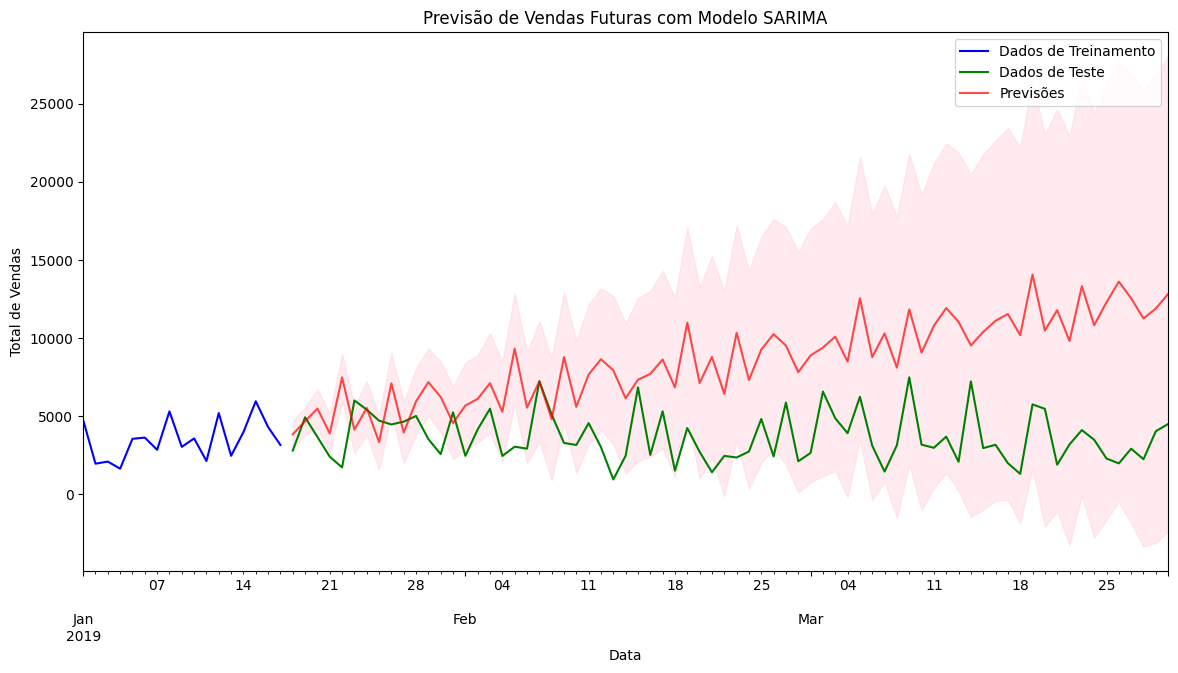

In [132]:
# Realizar previsões no conjunto de teste
forecast = model_sarima_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotar as previsões juntamente com os dados reais
plt.figure(figsize=(14, 7))
train_data.plot(label='Dados de Treinamento', color='blue')
test_data.plot(label='Dados de Teste', color='green')
forecast_mean.plot(label='Previsões', color='red', alpha=0.7)
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Previsão de Vendas Futuras com Modelo SARIMA')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.legend()
plt.show()
